In [3]:
%load_ext tensorboard

In [4]:
import numpy as np
import tensorflow as tf
import re
import pandas as pd
import spacy
import gc
from itertools import combinations
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix, vstack as sparse_vstack
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import Model, Input, layers
from tensorflow.keras.layers import Embedding, Dot, Reshape, Dense,Bidirectional, LSTM, GRU
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import skipgrams, pad_sequences
from keras.callbacks import TensorBoard

# **FASE 1**

In [5]:
# Step 1: Load data
train_df = pd.read_csv('train.csv', encoding='latin1')
test_df = pd.read_csv('test.csv', encoding='latin1')

def limpiar_texto(texto):
    texto = re.sub(r'[^\w\s]', '', str(texto)).lower()
    return texto

In [6]:
# # Step 2: Prepare data
# train_df['text_clean'] = train_df['text'].apply(limpiar_texto)
# test_df['text_clean'] = test_df['text'].apply(limpiar_texto)
# corpus = pd.concat([train_df['text_clean'], test_df['text_clean']]).tolist()

# #cuando aumentemos a todo el corpus poner estas 2 líenas solo para dataset compelto y elimianr lo de small_corpus
# tokenizer = Tokenizer()
# tokenizer.fit_on_texts(corpus)

# # Identificar las 10 palabras más utilizadas con significado (susantivos) cargando el modelo de spaCy en inglés
# try:
#     nlp = spacy.load("en_core_web_sm")
# except OSError:
#     import os
#     os.system("python -m spacy download en_core_web_sm")
#     nlp = spacy.load("en_core_web_sm")

# # Crear el set de stopwords incluyendo 'nan'
# stop_words = set(nlp.Defaults.stop_words)
# stop_words.add('nan')

# # Función para filtrar solo nombres con significado
# def es_nombre_con_significado(palabra):
#     if len(palabra) < 2 or palabra in stop_words:
#         return False
#     doc = nlp(palabra)
#     # Solo acepta si la palabra es un sustantivo (NOUN o PROPN)
#     return any(token.pos_ in {"NOUN", "PROPN"} for token in doc)

# # Aplicar filtro al vocabulario real
# palabras_filtradas = {
#     word: count for word, count in tokenizer.word_counts.items()
#     if es_nombre_con_significado(word)
# }

# # Ordenar y seleccionar top 10
# top_10 = sorted(palabras_filtradas.items(), key=lambda x: x[1], reverse=True)[:10]

# # Mostrar resultados
# print("\nTop 10 nombres con significado:")
# print("━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━")
# for idx, (palabra, freq) in enumerate(top_10, 1):
#     print(f"{idx:2}. {palabra:<15} → {freq:>6} apariciones")


# # Convertir textos a secuencias de enteros
# train_sequences = tokenizer.texts_to_sequences(train_df['text_clean'])
# test_sequences = tokenizer.texts_to_sequences(test_df['text_clean'])
# all_sequences = train_sequences + test_sequences

# # Diccionarios de palabras a índices y viceversa
# word2idx = tokenizer.word_index
# idx2word = {i: w for w, i in word2idx.items()}
# vocab_size = len(word2idx) + 1



# --- Step 2: Prepare data (10% train + 10% test) ---

# 1) Carga y limpieza
train_df['text_clean'] = train_df['text'].apply(limpiar_texto)
test_df ['text_clean'] = test_df ['text'].apply(limpiar_texto)

# 2) Muestreo 10% de cada uno
small_train_df = train_df.sample(frac=0.1, random_state=42)
small_test_df  = test_df.sample(frac=0.1, random_state=42)

train_corpus_small = small_train_df['text_clean'].tolist()
test_corpus_small  = small_test_df ['text_clean'].tolist()
small_corpus       = train_corpus_small + test_corpus_small

print(f"Frases usadas → train: {len(train_corpus_small)}, test: {len(test_corpus_small)}")

# 3) Tokenizer limitado a 5000 palabras + OOV
tokenizer = Tokenizer(num_words=5000, oov_token='<OOV>')
tokenizer.fit_on_texts(small_corpus)
vocab_size = 5000 + 1

# Diccionarios para después
word2idx = tokenizer.word_index
idx2word = {i:w for w,i in word2idx.items()}

# 4) Top-10 nombres con spaCy
try:
    nlp = spacy.load("en_core_web_sm")
except OSError:
    import os
    os.system("python -m spacy download en_core_web_sm")
    nlp = spacy.load("en_core_web_sm")

stop_words = set(nlp.Defaults.stop_words) | {'nan'}


Frases usadas → train: 2748, test: 482
Top 10 nombres con significado:
1. day             → 216 apariciones
2. love            → 124 apariciones
3. lol             → 117 apariciones
4. time            → 109 apariciones
5. today           → 108 apariciones
6. night           → 86 apariciones
7. thanks          → 83 apariciones
8. mothers         → 76 apariciones
9. hope            → 68 apariciones
10. morning         → 63 apariciones


# **FASE 2**

In [ ]:
def es_nombre(palabra):
    if len(palabra)<2 or palabra in stop_words: return False
    return any(t.pos_ in {"NOUN","PROPN"} for t in nlp(palabra))

filtradas = {w:c for w,c in tokenizer.word_counts.items() if es_nombre(w)}
top_10 = sorted(filtradas.items(), key=lambda x:x[1], reverse=True)[:10]
print("Top 10 nombres con significado:")
for i,(w,f) in enumerate(top_10,1):
    print(f"{i}. {w:<15} → {f} apariciones")

# 5) Secuencias sólo del 10%
train_sequences_small = tokenizer.texts_to_sequences(train_corpus_small)
test_sequences_small  = tokenizer.texts_to_sequences(test_corpus_small)
all_sequences        = train_sequences_small + test_sequences_small

In [7]:
# # Step 3: Generación de pares con ventanas 2 y 4
# pairs_dict = {'window_2': [], 'window_4': []}

# for seq in all_sequences:
#     # Ventana 2
#     sg_pairs_2, _ = skipgrams(seq, vocab_size, window_size=2, negative_samples=0)
#     pairs_dict['window_2'].extend(sg_pairs_2)

#     # Ventana 4
#     sg_pairs_4, _ = skipgrams(seq, vocab_size, window_size=4, negative_samples=0)
#     pairs_dict['window_4'].extend(sg_pairs_4)

In [10]:
# Step 3: Generación de pares con ventanas 2 y 4
pairs_dict = {'window_2': []}

for seq in all_sequences:
    # Ventana 2
    sg_pairs_2, _ = skipgrams(seq, vocab_size, window_size=2, negative_samples=0)
    pairs_dict['window_2'].extend(sg_pairs_2)

In [11]:
# Step 4: One-hot encoding optimizado
def sparse_onehot(batch, vocab_size):
    rows = np.arange(len(batch))
    cols = np.array(batch).flatten()
    data = np.ones_like(cols, dtype=np.float32)
    return csr_matrix((data, (rows, cols)), shape=(len(batch), vocab_size), dtype=np.float32)

In [17]:
#AMPLIAR EBEDDING_SIZES, BATCH_SIZE, epochs

# Step 5: Entrenamiento de modelos (guardando también los objetos Keras Model)
embedding_sizes  = [45]               # cuando funcione, pon [45, 312, 752]
window_sizes     = ['window_2']      # añade 'window_4' para la otra ventana
loss_histories   = {}
final_embeddings = {}
models           = {}                 # <- aquí guardaremos cada modelo

for emb_size in embedding_sizes:
    for window in window_sizes:
        current_pairs = pairs_dict[window]
        if not current_pairs:
            continue

        # Preparar datos
        targets, contexts = zip(*current_pairs)
        targets  = np.array(targets,  dtype='int32')
        contexts = np.array(contexts, dtype='int32')

        # One-hot encoding (tu versión original)
        batch_size       = 64
        X_target_sparse  = []
        X_context_sparse = []
        for i in range(0, len(targets), batch_size):
            X_target_sparse.append(sparse_onehot(targets[i:i+batch_size], vocab_size))
            X_context_sparse.append(sparse_onehot(contexts[i:i+batch_size], vocab_size))
            gc.collect()
        X_target = sparse_vstack(X_target_sparse)
        X_context= sparse_vstack(X_context_sparse)
        X_train  = [X_target, X_context]
        y_train  = np.ones(X_target.shape[0], dtype=np.float16)

        # Construir modelo
        shared_embedding_layer = layers.Dense(
            emb_size, use_bias=False, name=f'embedding_{emb_size}_{window}'
        )
        target_input  = Input(shape=(vocab_size,), name='target_onehot')
        context_input = Input(shape=(vocab_size,), name='context_onehot')
        target_vector = shared_embedding_layer(target_input)
        context_vector= shared_embedding_layer(context_input)
        dot_product   = layers.Dot(axes=-1)([target_vector, context_vector])
        dot_product   = layers.Reshape((1,))(dot_product)
        output        = layers.Dense(1, activation='sigmoid')(dot_product)

        model = Model(inputs=[target_input, context_input], outputs=output)
        model.compile(
            loss='binary_crossentropy',
            optimizer=keras.optimizers.Adam(0.025),
            metrics=['accuracy']
        )

        # Guardar el modelo en el diccionario antes de entrenar
        key = f'emb_{emb_size}_{window}'
        models[key] = model

        # Entrenar
        history = model.fit(
            X_train,
            y_train,
            epochs=2,
            batch_size=64,
            callbacks=[TensorBoard(log_dir='logs')],
            verbose=0
        )

        # Guardar historial y embeddings
        loss_histories[key]   = history.history['loss']
        final_embeddings[key] = shared_embedding_layer.get_weights()[0]



In [18]:
# Recorre cada modelo en el diccionario y muestra su summary
for key, mdl in models.items():
    print(f"\n=== Summary de {key} ===")
    mdl.summary()



=== Summary de emb_45_window_2 ===


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ target_onehot       │ (None, 5001)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ context_onehot      │ (None, 5001)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_45_windo… │ (None, 45)        │    225,045 │ target_onehot[0]… │
│ (Dense)             │                   │            │ context_onehot[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dot_1 (Dot)         │ (None, 1)         │          0 │ embedding_45_win… │
│                     │                   │            │ embedding_45_win… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_1 (Reshape) │ (None, 1)         │          0 │ dot_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1)         │          2 │ reshape_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 675,143 (2.58 MB)

 Trainable params: 225,047 (879.09 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 450,096 (1.72 MB)

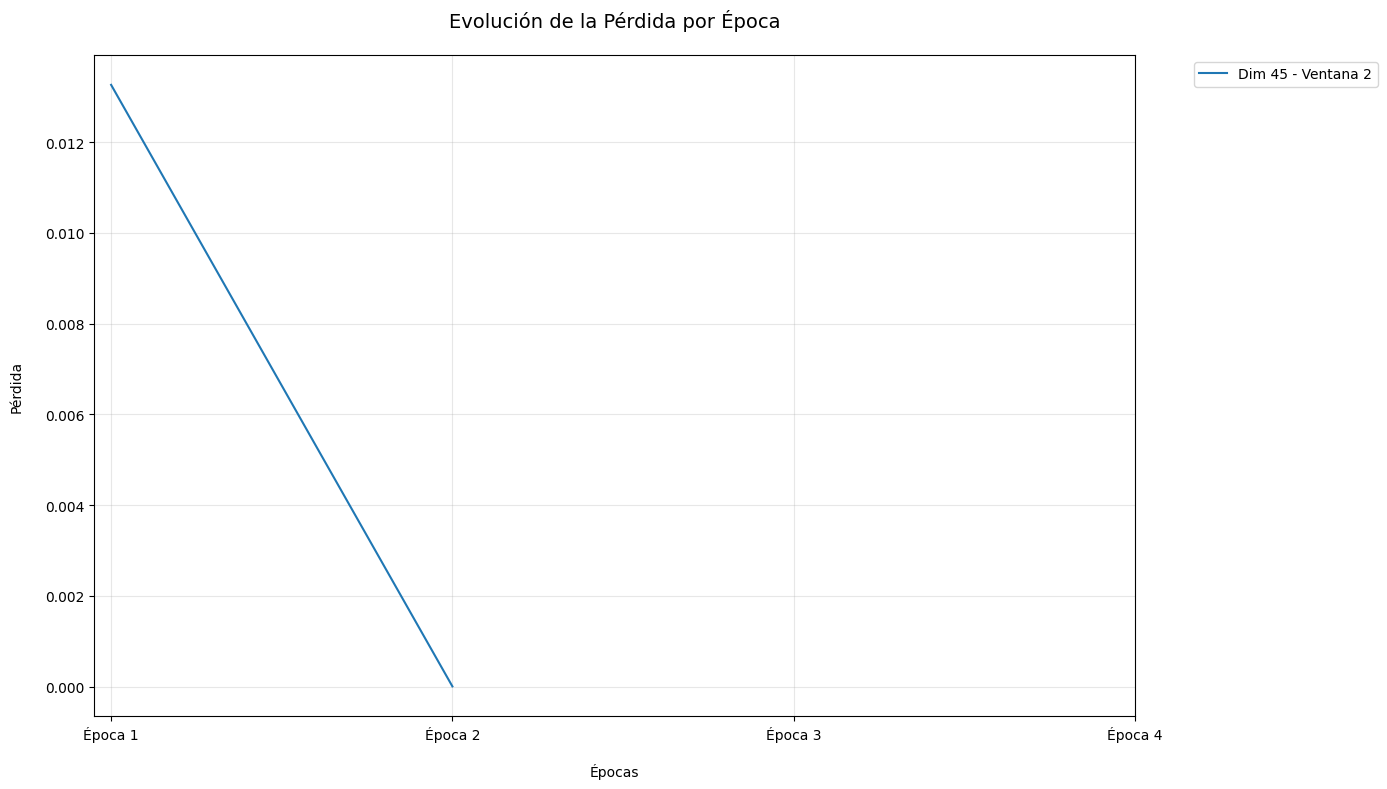

In [19]:
# Step 6: Visualización de la pérdida
plt.figure(figsize=(14, 8))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

for idx, emb_size in enumerate(embedding_sizes):
    for window in window_sizes:
        key = f'emb_{emb_size}_{window}'
        if key in loss_histories:
            plt.plot(
                loss_histories[key],
                linestyle='--' if 'window_4' in key else '-',
                color=colors[idx],
                label=f'Dim {emb_size} - Ventana {window.split("_")[1]}'
            )

plt.title('Evolución de la Pérdida por Época', pad=20, fontsize=14)
plt.xlabel('Épocas', labelpad=15)
plt.ylabel('Pérdida', labelpad=15)
plt.xticks(range(4), [f'Época {i+1}' for i in range(4)])
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('loss_evolution.png', dpi=300, bbox_inches='tight')
plt.show()


In [21]:
# Example: vector for "love"
idx = word2idx["love"]

print(f"Embedding for 'love':\n{embeddings[idx]}")

Embedding for 'love':
[-0.33216602 -0.27406782 -0.38246113 -0.28168505 -0.06815907  0.38789436
 -0.06419466  0.612109    0.48774612  0.32662192  0.1506963   0.38084257
  0.29669684 -0.73506224  0.40065342 -0.58351105 -0.01186757  0.38099456
  0.3473295   0.4188103   0.488843   -0.128478    0.36257696 -0.61303705
  0.06201477 -0.48797283 -0.4926789  -0.20480905  0.4752332  -0.24312648
 -0.5632082   0.41868424 -0.38064283  0.49042392  0.5258841   0.13773344
 -0.31068546 -0.54205215 -0.25342172  0.3709232  -0.46184993 -0.49570927
 -0.13260059 -0.4189586   0.39213663]


In [26]:


# 1) Lista de las 10 palabras puras (sin frecuencia)
top_10_words = [w for w,_ in top_10]

# 2) Extrae los índices solo de las que realmente estén en tu vocabulario
indices = []
words   = []
for w in top_10_words:
    if w in word2idx:
        indices.append(word2idx[w])
        words.append(w)
    else:
        print(f"Advertencia: '{w}' no está en el vocabulario")

# 3) Recorre cada modelo en final_embeddings
for model_key, emb_matrix in final_embeddings.items():
    # 4) Submatriz de solo las top palabras
    submat = emb_matrix[indices]            # (n_words, emb_dim)

    # 5) Calcula similitud de coseno
    sim_mat = cosine_similarity(submat)     # (n_words, n_words)

    # 6) Construye DataFrame y muestra
    print(f"\n— Similitud de coseno para {model_key} —")
    df_sim = pd.DataFrame(sim_mat, index=words, columns=words)
    display(df_sim)




— Similitud de coseno para emb_45_window_2 —


,day,love,lol,time,today,night,thanks,mothers,hope,morning
day,1.000000,0.653078,0.607785,0.663624,0.694660,0.449182,0.686236,0.825864,0.715246,0.685013
love,0.653078,1.000000,0.814705,0.743281,0.748994,0.590178,0.695596,0.774037,0.754603,0.810588
lol,0.607785,0.814705,1.000000,0.664151,0.683235,0.586442,0.724086,0.651575,0.735028,0.785310
time,0.663624,0.743281,0.664151,1.000000,0.755117,0.489040,0.654489,0.761450,0.819310,0.833896
today,0.694660,0.748994,0.683235,0.755117,1.000000,0.571647,0.717994,0.789123,0.825422,0.768635
night,0.449182,0.590178,0.586442,0.489040,0.571647,1.000000,0.586019,0.485115,0.581536,0.531135
thanks,0.686236,0.695596,0.724086,0.654489,0.717994,0.586019,1.000000,0.665981,0.718639,0.630960
mothers,0.825864,0.774037,0.651575,0.761450,0.789123,0.485115,0.665981,1.000000,0.791962,0.825093
hope,0.715246,0.754603,0.735028,0.819310,0.825422,0.581536,0.718639,0.791962,1.000000,0.844681
morning,0.685013,0.810588,0.785310,0.833896,0.768635,0.531135,0.630960,0.825093,0.844681,1.000000


In [29]:


# Define aquí tres grupos basados en tu top-10
grupos = {
    'Día/Mañana':     ['day', 'today', 'morning'],
    'Emoción Positiva':['love', 'hope', 'thanks'],
    'Risa/Conversación':['lol', 'thanks', 'mothers']  # ejemplo mixto
}

for model_key, emb_matrix in final_embeddings.items():
    print(f"\n=== Similitudes para {model_key} ===")
    # Extrae solo los vectores de tus 10 palabras
    submat = emb_matrix[indices]           # (10, emb_dim)
    sim_mat = cosine_similarity(submat)    # (10, 10)

    # Mapea palabra -> posición en 'words'
    pos = {w:i for i,w in enumerate(words)}

    for nombre, group in grupos.items():
        # Filtra solo los que realmente están en tu top
        valid = [w for w in group if w in pos]
        idxs  = [pos[w] for w in valid]
        if len(idxs) < 2:
            print(f"  * Grupo «{nombre}» tiene <2 palabras válidas, omito.")
            continue

        sims = []
        print(f"\n  Grupo «{nombre}»: {valid}")
        for i,j in combinations(idxs, 2):
            s = sim_mat[i, j]
            sims.append(s)
            print(f"    Sim({words[i]}, {words[j]}) = {s:.3f}")

        print(f"    → Similitud media = {np.mean(sims):.3f}")




=== Similitudes para emb_45_window_2 ===

  Grupo «Día/Mañana»: ['day', 'today', 'morning']
    Sim(day, today) = 0.695
    Sim(day, morning) = 0.685
    Sim(today, morning) = 0.769
    → Similitud media = 0.716

  Grupo «Emoción Positiva»: ['love', 'hope', 'thanks']
    Sim(love, hope) = 0.755
    Sim(love, thanks) = 0.696
    Sim(hope, thanks) = 0.719
    → Similitud media = 0.723

  Grupo «Risa/Conversación»: ['lol', 'thanks', 'mothers']
    Sim(lol, thanks) = 0.724
    Sim(lol, mothers) = 0.652
    Sim(thanks, mothers) = 0.666
    → Similitud media = 0.681


# **FASE 3**

In [35]:
# --- FASE 3: DOS RNN SECUENCIALES CON EMBEDDINGS PRE-ENTRENADOS ---

# Parámetros generales
maxlen       = 50
batch_rnn    = 64
epochs_rnn   = 5
learning_rate= 0.025

# 1) Usa SMALL_TRAIN_DF / SMALL_TEST_DF y quita filas sin etiqueta
small_train_df.dropna(subset=['sentiment'], inplace=True)
small_test_df .dropna(subset=['sentiment'], inplace=True)

texts_train = small_train_df['text_clean'].tolist()
texts_test  = small_test_df ['text_clean'].tolist()

# 2) LabelEncoder para convertir strings → enteros
le      = LabelEncoder()
y_train = le.fit_transform(small_train_df['sentiment'])
y_test  = le.transform( small_test_df ['sentiment'])
y_train = y_train.astype('int32')
y_test  = y_test.astype('int32')
print("Clases sentiment codificadas:", le.classes_)

# 3) Secuencias + padding (reusa el tokenizer de Fase 2)
seq_train = tokenizer.texts_to_sequences(texts_train)
seq_test  = tokenizer.texts_to_sequences(texts_test)
X_train   = pad_sequences(seq_train, maxlen=maxlen, padding='post')
X_test    = pad_sequences(seq_test,  maxlen=maxlen, padding='post')

# 4) Crea datasets optimizados
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)) \
                         .shuffle(len(X_train)) \
                         .batch(batch_rnn) \
                         .prefetch(tf.data.AUTOTUNE)
test_ds  = tf.data.Dataset.from_tensor_slices((X_test,  y_test)) \
                         .batch(batch_rnn) \
                         .prefetch(tf.data.AUTOTUNE)

# 5) Elige qué embeddings usar
key_A = 'emb_45_window_2'
key_B = 'emb_45_window_2'  # cámbialo por 'emb_312_window_4', etc.
emb_A = final_embeddings[key_A]
emb_B = final_embeddings[key_B]
vocab_sz = vocab_size

# 6) Construye modelo A (Bi-LSTM + Bi-GRU)
model_A = keras.Sequential([
    Embedding(input_dim=vocab_sz,
              output_dim=emb_A.shape[1],
              weights=[emb_A],
              mask_zero=True,
              trainable=False),
    Bidirectional(LSTM(64, return_sequences=True)),
    Bidirectional(GRU(64)),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
], name='Model_A')
model_A.compile(
    loss='binary_crossentropy',
    optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
    metrics=['accuracy']
)
print("\n--- Model A Summary ---")
model_A.summary()

# 7) Construye modelo B (Bi-LSTM simple)
model_B = keras.Sequential([
    Embedding(input_dim=vocab_sz,
              output_dim=emb_B.shape[1],
              weights=[emb_B],
              mask_zero=True,
              trainable=False),
    Bidirectional(LSTM(64)),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
], name='Model_B')
model_B.compile(
    loss='binary_crossentropy',
    optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
    metrics=['accuracy']
)
print("\n--- Model B Summary ---")
model_B.summary()




Clases sentiment codificadas: ['negative' 'neutral' 'positive']

--- Model A Summary ---


Model: "Model_A"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ ?                      │       225,045 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_5 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_6 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 225,045 (879.08 KB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 225,045 (879.08 KB)


--- Model B Summary ---


Model: "Model_B"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)         │ ?                      │       225,045 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_7 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 225,045 (879.08 KB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 225,045 (879.08 KB)

In [36]:
# 8) Entrena ambos
print("\n>>> Entrenando Model A")
history_A = model_A.fit(
    train_ds,
    validation_data=test_ds,
    epochs=epochs_rnn
)

print("\n>>> Entrenando Model B")
history_B = model_B.fit(
    train_ds,
    validation_data=test_ds,
    epochs=epochs_rnn
)




>>> Entrenando Model A
Epoch 1/5
43/43 ━━━━━━━━━━━━━━━━━━━━ 11s 53ms/step - accuracy: 0.4038 - loss: -4.0648 - val_accuracy: 0.4028 - val_loss: 22.9313
Epoch 2/5
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.4228 - loss: -38.6800 - val_accuracy: 0.4028 - val_loss: 92.4975
Epoch 3/5
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.4083 - loss: 0.9410 - val_accuracy: 0.4028 - val_loss: 180.0601
Epoch 4/5
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.4058 - loss: -310.9843 - val_accuracy: 0.4028 - val_loss: 372.4270
Epoch 5/5
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.4184 - loss: -543.4957 - val_accuracy: 0.4028 - val_loss: 326.1503

>>> Entrenando Model B
Epoch 1/5
43/43 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.3903 - loss: -1.1385 - val_accuracy: 0.4028 - val_loss: 7.2837
Epoch 2/5
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4161 - loss: -14.8098 - val_accuracy: 0.4028 - val_loss: 26.6535
Epoch 3/5
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/ste

=== Train Confusion Matrices ===
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


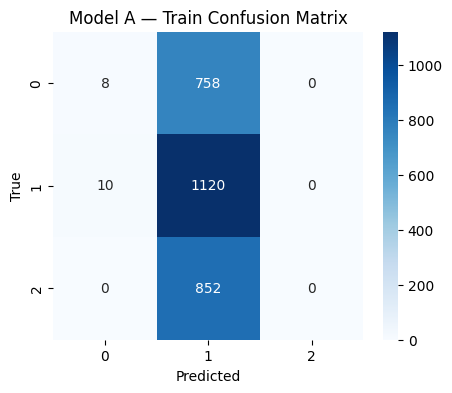

86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


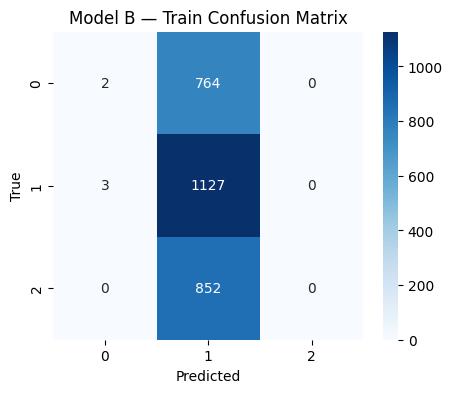

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Solo dibujamos la matriz de confusión para TRAIN
print("=== Train Confusion Matrices ===")
for name, model in [('Model A', model_A), ('Model B', model_B)]:
    y_train_pred = (model.predict(X_train) > 0.5).astype('int32').flatten()
    cm_train     = confusion_matrix(y_train, y_train_pred)

    plt.figure(figsize=(5,4))
    sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{name} — Train Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()



=== Evaluación en TEST ===

--- Model A ---
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step

Classification Report:
              precision    recall  f1-score   support

    negative       0.00      0.00      0.00       113
     neutral       0.40      1.00      0.57       145
    positive       0.00      0.00      0.00       102

    accuracy                           0.40       360
   macro avg       0.13      0.33      0.19       360
weighted avg       0.16      0.40      0.23       360



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


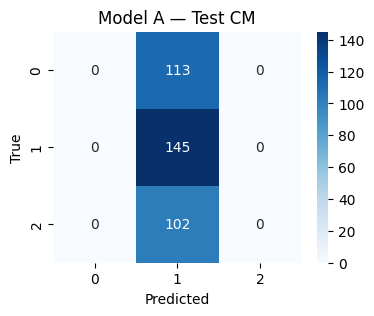


--- Model B ---
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

Classification Report:
              precision    recall  f1-score   support

    negative       0.00      0.00      0.00       113
     neutral       0.40      1.00      0.57       145
    positive       0.00      0.00      0.00       102

    accuracy                           0.40       360
   macro avg       0.13      0.33      0.19       360
weighted avg       0.16      0.40      0.23       360



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


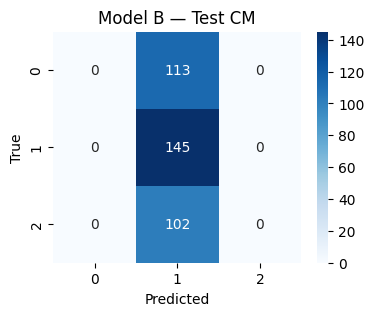

In [46]:
print("\n=== Evaluación en TEST ===")
for name, model in [('Model A', model_A), ('Model B', model_B)]:
    print(f"\n--- {name} ---")
    # Predicción en test
    y_test_pred = (model.predict(X_test) > 0.5).astype('int32').flatten()
    # Matriz de confusión
    cm_test = confusion_matrix(y_test, y_test_pred)
    # Métricas
    print("\nClassification Report:")
    print(classification_report(y_test, y_test_pred, target_names=le.classes_))
    # Gráfico
    plt.figure(figsize=(4,3))
    sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{name} — Test CM')
    plt.xlabel('Predicted'); plt.ylabel('True')
    plt.show()

In [49]:
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

# 1) Saca una frase de small_test_df (por ejemplo la primera)
sample_text = small_test_df['text_clean'].iloc[0]
print("Sample text:", sample_text)

# 2) Convierte a secuencia y pad
seq = tokenizer.texts_to_sequences([sample_text])
seq_pad = pad_sequences(seq, maxlen=maxlen, padding='post')

# 3) Predicción con Model A
prob_A = model_A.predict(seq_pad)[0,0]
pred_A = int(prob_A > 0.5)
print(f"\nModel A prediction → prob_positive = {prob_A:.3f}, class = {pred_A}")

# 4) Predicción con Model B
prob_B = model_B.predict(seq_pad)[0,0]
pred_B = int(prob_B > 0.5)
print(f"Model B prediction → prob_positive = {prob_B:.3f}, class = {pred_B}")


Sample text: screw the fact you cant post long updates on twitter
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step

Model A prediction → prob_positive = 1.000, class = 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
Model B prediction → prob_positive = 1.000, class = 1
